<a href="https://colab.research.google.com/github/DmitryiLaptev/Collab/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_1_(%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib as mpl
import psycopg2
import pandas as pd
import matplotlib.ticker as mticker
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

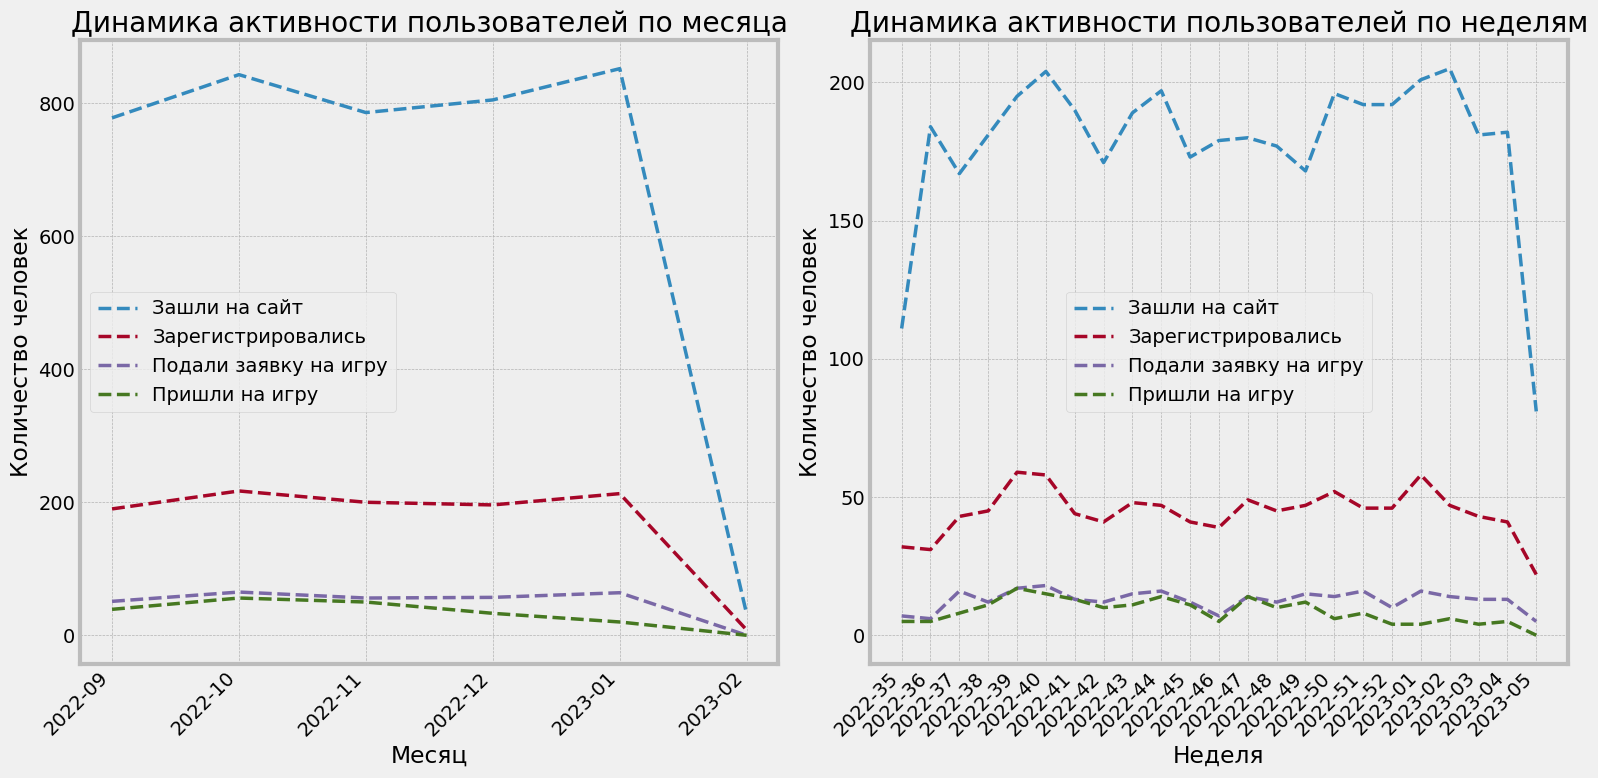

In [ ]:
conn = psycopg2.connect(host="158.160.52.106", 
                        port=5432, 
                        dbname="postgres", 
                        user="student", 
                        password="JvLda93aA")

with conn.cursor() as cur:
  cur.execute("""
                  SELECT to_char(date_trunc('month', c.visit_dttm), 'YYYY-MM') AS month, 
                        count(distinct c.client_rk) AS client, 
                        count(distinct a.account_rk) AS account, 
                        count(distinct a2.account_rk) AS application, 
                        count(distinct a2.account_rk) FILTER(WHERE g.game_flg = 1) AS game_flg         
                  FROM msu_analytics.client c 
                  left JOIN msu_analytics.account a using (client_rk) 
                  left JOIN msu_analytics.application a2 using (account_rk) 
                  left JOIN msu_analytics.game g using (game_rk) 
                  GROUP BY date_trunc('month', c.visit_dttm) 
                  ORDER BY month
            """)
  merged_month_quantity = cur.fetchall()

  cur.execute("""
                  SELECT to_char(date_trunc('week', c.visit_dttm), 'YYYY-WW') AS week, 
                        count(distinct c.client_rk) AS client, 
                        count(distinct a.account_rk) AS account, 
                        count(distinct a2.account_rk) AS application, 
                        count(distinct a2.account_rk) FILTER(WHERE g.game_flg = 1) AS game         
                  FROM msu_analytics.client c 
                  left JOIN msu_analytics.account a using (client_rk) 
                  left JOIN msu_analytics.application a2 using (account_rk) 
                  left JOIN msu_analytics.game g using (game_rk) 
                  GROUP BY date_trunc('week', c.visit_dttm) 
                  ORDER BY week
            """)
  merged_week_quantity = cur.fetchall()
  df_month = pd.DataFrame(merged_month_quantity, columns=['month', 'client', 'account', 'application', 'game'])
  df_week = pd.DataFrame(merged_week_quantity, columns=['week', 'client', 'account', 'application', 'game'])

  plt.style.use('bmh')
  mpl.rcParams['lines.linestyle'] = '--'
  plt.rcParams.update({'figure.autolayout': True})

legend = ['Зашли на сайт', 'Зарегистрировались', 'Подали заявку на игру', 'Пришли на игру']

f = plt.figure(figsize=(16, 8))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(df_month['month'], df_month.iloc[:, 1:], linewidth=2.5)
ax1.legend(legend)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set(xlabel='Месяц',
        ylabel='Количество человек',
        title='Динамика активности пользователей по месяца')
ax1.grid(True)


ax2.plot(df_week['week'], df_week.iloc[:, 1:], linewidth=2.5)
ax2.legend(legend)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set(xlabel='Неделя',
        ylabel='Количество человек',
        title='Динамика активности пользователей по неделям')
ax2.grid(True)


f.tight_layout()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

plot_titles = df_month.iloc[0:, 0].tolist()

fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=plot_titles)

row = 1
col = 1

for plot in range(len(plot_titles)):
  fig.add_trace(go.Funnel(
                          y = ['Зашли на сайт', 'Зарегистрировались', 'Подали заявку на игру', 'Пришли на игру'],
                          x = df_month.iloc[plot, 1:].tolist(),
                          textposition = "inside",
                          textinfo = "value+percent initial",
                          opacity = 0.65,marker = {"color": ["blue", "red", "purple", "green"]}
                          ),
                row=row,
                col=col)
  
  col += 1
  if col > 2:
    row += 1
    col = 1

fig.update_layout(height=800, width=1800,
                  margin = {"l": 0, "r": 0},
                  title_text="Воронки с конверсией по месяцам")
fig.show()

Выводы:

1.   Только 25% зашедших на сайт регистрируется на игру, а значит нужно привлекать людей к регистрации (с помощью предлажения скидок, бесплатных услуг или розыгрышей среди зарегестрировавшихся).
2.   Примерно 30% зарегестрировашихся пользователей подают заявку на игру. Чтобы увеличить это число можно например предложить скидку на первую игру или выдовать какие-нибудь небольшие подарки за регистрацию на первую игру.
3.   Если человек подал заявку, то с 80% шансом он придёт на игру.



